## Detecting Pneumonia
The following notebook will create an algorithm to detech pneumonia from CT-scans of the thorax.

In [3]:
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import os

from IPython.display import display



ds_train = keras.preprocessing.image_dataset_from_directory(
    '../dataset/train',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)

ds_valid = keras.preprocessing.image_dataset_from_directory(
    '../dataset/val',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)


Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.


In [5]:
#Data augmentation
keras.layers.experimental.preprocessing.RandomTranslation(
    (-0.2, 0.3),
    (-0.2, 0.3),
    fill_mode="reflect",
    interpolation="bilinear",
    seed=None,
    name=None
)

In [13]:
# Models
model = keras.Sequential([
    
    # First conv block
    layers.Conv2D(
        filters=32, 
        kernel_size=5, 
        activation="relu", 
        padding="same", 
        input_shape=[128, 128, 3]
    ),
    layers.MaxPool2D(),
    
    # Second conv block
    layers.Conv2D(
        filters=64, 
        kernel_size=3, 
        activation="relu", 
        padding='same'
    ),
    layers.MaxPool2D(),

    # Classifier Head
    layers.Flatten(),
    layers.Dense(units=6, activation="relu"),
    layers.Dense(units=1, activation="sigmoid"),
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 128, 128, 32)      2432      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 393222    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [22]:
# With 17 epochs, takes almost 10mns to run on my Mac
model.compile(
    optimizer = keras.optimizers.Adam(epsilon=0.01),
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=17,
    verbose=0
)

KeyboardInterrupt: 

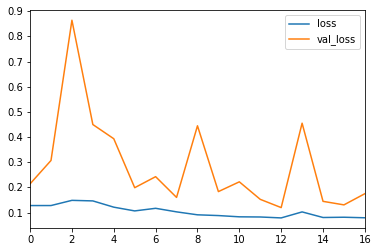

In [20]:
import pandas as pd

history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()

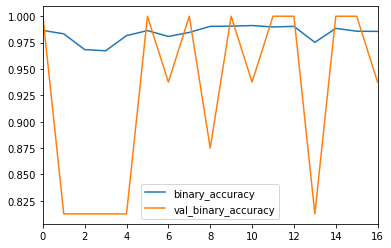

In [21]:
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

Ran with 12 epochs and then 17 epochs but the model is far too demanding for a laptop. 

Results seems to work well on the training data (blue lines) with low loss and high accuracy, however the images show high volatility with the test data (orange lines). Fitting the model with 12 epochs resulted in test accuracy much less volatile, however still well below training data (too much overfitting)

## k-Nearest Neighbors

Based off this <a href="https://www.pyimagesearch.com/2016/08/08/k-nn-classifier-for-image-classification/">article</a>

In [73]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import argparse
import pathlib
import os
import jwt
import cv2
import numpy as np
import imutils

def image_to_feature_vector(image, size=(64, 64)):
    return cv2.resize(image, size).flatten()

# get images
def get_image_paths(rootPath):
    imagePaths = []
    for file in os.listdir(rootPath):
        if(file[0] == '.'): continue
        for f in os.listdir(rootPath+file):
            if(f[0] == '.'): continue
            imagePaths.append(os.path.abspath(rootPath+'/'+file+'/'+f))
#             print(os.path.abspath(file+'/'+f).split(os.path.sep)[-2])
    return imagePaths

def extract_color_histogram(image, bins=(8, 8, 8)):
	# extract a 3D color histogram from the HSV color space using
	# the supplied number of `bins` per channel
	hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
	hist = cv2.calcHist([hsv], [0, 1, 2], None, bins,
		[0, 180, 0, 256, 0, 256])
	# handle normalizing the histogram if we are using OpenCV 2.4.X
	if imutils.is_cv2():
		hist = cv2.normalize(hist)
	# otherwise, perform "in place" normalization in OpenCV 3 (I
	# personally hate the way this is done
	else:
		cv2.normalize(hist, hist)
	# return the flattened histogram as the feature vector
	return hist.flatten()

all_images = get_image_paths('../dataset/train/')

rawImages = []
features = []
labels = []

for (i, imagePath) in enumerate(all_images):
    image = cv2.imread(imagePath)
    label = imagePath.split(os.path.sep)[-2]
    
    pixels = image_to_feature_vector(image)
    hist = extract_color_histogram(image)
    
    rawImages.append(pixels)
    features.append(hist)
    labels.append(label)
    
    if i > 0 and i % 500 == 0:
        print("[INFO] processed {}/{}".format(i, len(all_images)))

rawImages = np.array(rawImages)
features = np.array(features)
labels = np.array(labels)
print("[INFO] pixels matrix: {:.2f}MB".format(
	rawImages.nbytes / (1024 * 1000.0)))
print("[INFO] features matrix: {:.2f}MB".format(
	features.nbytes / (1024 * 1000.0)))

(trainRI, testRI, trainRL, testRL) = train_test_split(
	rawImages, labels, test_size=0.25, random_state=42)
(trainFeat, testFeat, trainLabels, testLabels) = train_test_split(
	features, labels, test_size=0.25, random_state=42)

# train and evaluate a k-NN classifer on the raw pixel intensities
print("[INFO] evaluating raw pixel accuracy...")
model = KNeighborsClassifier(n_neighbors=3)
model.fit(trainRI, trainRL)
acc = model.score(testRI, testRL)
print("[INFO] raw pixel accuracy: {:.2f}%".format(acc * 100))

# train and evaluate a k-NN classifer on the histogram
# representations
print("[INFO] evaluating histogram accuracy...")
model = KNeighborsClassifier(n_neighbors=3)
model.fit(trainFeat, trainLabels)
acc = model.score(testFeat, testLabels)
print("[INFO] histogram accuracy: {:.2f}%".format(acc * 100))


[INFO] processed 500/5216
[INFO] processed 1000/5216
[INFO] processed 1500/5216
[INFO] processed 2000/5216
[INFO] processed 2500/5216
[INFO] processed 3000/5216
[INFO] processed 3500/5216
[INFO] processed 4000/5216
[INFO] processed 4500/5216
[INFO] processed 5000/5216
[INFO] pixels matrix: 62.59MB
[INFO] features matrix: 10.43MB
[INFO] evaluating raw pixel accuracy...
[INFO] raw pixel accuracy: 91.03%
[INFO] evaluating histogram accuracy...
[INFO] histogram accuracy: 83.28%


First run on the train images produced a 

- raw pixel accuracy = 91.03%
- histogram accuracy = 83.28%

Still have to look into how exactly this accuracy is calculated and if I'm doing it right...

In [68]:
'''
Jupyter is being annoying and not connecting to my terminal installs
'''
# import sys
# !{sys.executable} -m pip install imutils

  Using cached imutils-0.5.4.tar.gz (17 kB)
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25859 sha256=83c51aec93a7308a19e36bb428b3df1cf8cd3596663420c6dea637a454024bed
  Stored in directory: /Users/ryanheadley/Library/Caches/pip/wheels/86/d7/0a/4923351ed1cec5d5e24c1eaf8905567b02a0343b24aa873df2
Successfully built imutils
You should consider upgrading via the '/Users/ryanheadley/opt/anaconda3/bin/python -m pip install --upgrade pip' command.
